## 1. Inspecting velocyto code

In [2]:
import os
import velocyto as vcy
from velocyto.commands import run10x
# Find the installation path of the velocyto package
velocyto_path = os.path.dirname(vcy.__file__)

# Locate the run10x.py file
run10x_path = os.path.join(velocyto_path, 'commands', 'run10x.py')

# Print the path to verify
print(f"run10x.py is located at: {run10x_path}")

run10x.py is located at: /ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/velocyto/commands/run10x.py


In [5]:
def print_run10x_code():
    with open(run10x_path, 'r') as file:
        print(file.read())

# Call the function to print the code
# print_run10x_code()

import sys
import os
import glob
import re
import gzip
import click
import numpy as np
import csv
from collections import defaultdict
import logging
from typing import *
import velocyto as vcy
from ._run import _run


logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)


@click.command(short_help="Runs the velocity analysis for a Chromium Sample")
@click.argument("samplefolder",
                type=click.Path(exists=True,
                                file_okay=False,
                                dir_okay=True,
                                readable=True,
                                writable=True,
                                resolve_path=True))
@click.argument("gtffile",
                type=click.Path(exists=True,
                                file_okay=True,
                                dir_okay=False,
                                readable=True,
                                resolve_path=True))
@cli

## 2. Inspecting velocyto output loom

In [1]:
import scvelo as scv
import scanpy as sc
import velocyto as vcy
import cellrank as cr
import loompy as lp

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt

import os
import sys
import logging

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', facecolor='white', dpi=100, frameon=False)
cr.settings.verbosity = 2

#### Load anndata

In [2]:
# data directory and files for pre-prared anndata
data_dir_aggr = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/outs/'
adata_atac_path = os.path.join(data_dir_aggr, 'adata_aggregated_peak.leiden.h5ad')
adata_rna_path = os.path.join(data_dir_aggr, 'adata_aggregated_gene.leiden.h5ad')

#### Inspect pre-processed anndata for all samples

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


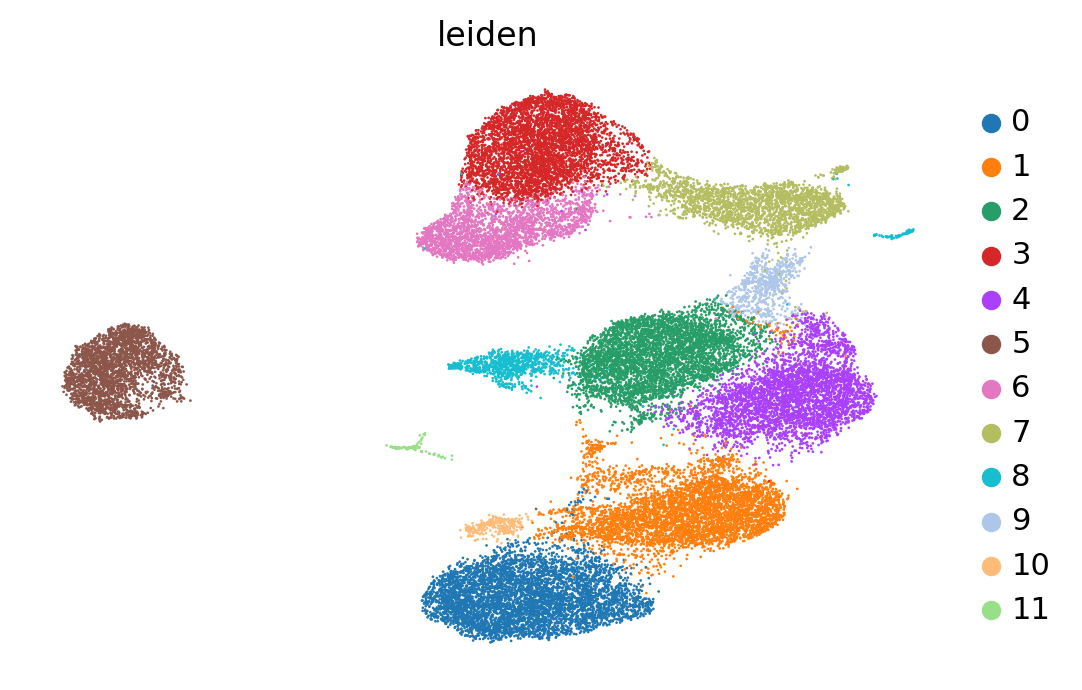

In [3]:
adata_rna = sc.read_h5ad(adata_rna_path)
#umap colors by both cell metadata and var.names (gene_names)
sc.pl.umap(adata_rna, color=['leiden'], frameon=False) 

In [19]:
adata_rna

AnnData object with n_obs × n_vars = 32418 × 23090
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sample_batch'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap', 'X_umap_features'
    varm: 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'counts'
    obsp: '

#### Inspect loom files (day3_4 sample - original # of cells > 11,127)

In [4]:
# data directory and files for velocyto outputs
#time point 1
data_dir_vcy_day0_2 = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_day0_2/velocyto'
loom_file_day0_2 = os.path.join(data_dir_vcy_day0_2, 'multiome_1st_donor_UPMC_day0_2.loom')
#time point 2
data_dir_vcy_day3_4 = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_day3_4/velocyto'
loom_file_day3_4 = os.path.join(data_dir_vcy_day3_4, 'multiome_1st_donor_UPMC_day3_4.loom')
#time point 3
data_dir_vcy_day5_6 = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_day5_6/velocyto'
loom_file_day5_6 = os.path.join(data_dir_vcy_day5_6, 'multiome_1st_donor_UPMC_day5_6.loom')

In [10]:
# Create an analysis object using loompy {gene by cell matrix}
ds = lp.connect(loom_file)
print(ds.shape)
# List all available layers in the LayerManager object
print(ds.layers.keys())
# Global attributes
print(ds.attrs.keys())
# Obs for each gene and cell
print(ds.ra.keys()); print(ds.ca.keys())
# graphs if saved in the loom (most prob not)
ds.close() # at the end of the analysis so that the hdf5 is not corrputed


(36601, 9894)
['', 'ambiguous', 'spliced', 'unspliced']
['CreationDate', 'LOOM_SPEC_VERSION', 'velocyto.__version__', 'velocyto.logic']
['Accession', 'Chromosome', 'End', 'Gene', 'Start', 'Strand']
['CellID', 'Clusters']


#### Create anndata by joing the loom files to the existing anndata

In [5]:
ldata1 = scv.read(loom_file_day0_2, cache=True)
ldata2 = scv.read(loom_file_day3_4, cache=True)
ldata3 = scv.read(loom_file_day5_6, cache=True)

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
# rename barcodes in order to merge:
barcodes = [bc.split(':')[1] for bc in ldata1.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_10' for bc in barcodes]
ldata1.obs.index = barcodes

barcodes = [bc.split(':')[1] for bc in ldata2.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_11' for bc in barcodes]
ldata2.obs.index = barcodes

barcodes = [bc.split(':')[1] for bc in ldata3.obs.index.tolist()]
barcodes = [bc[0:len(bc)-1] + '_9' for bc in barcodes]
ldata3.obs.index = barcodes



In [7]:
# make variable names unique
ldata1.var_names_make_unique()
ldata2.var_names_make_unique()
ldata3.var_names_make_unique()


In [8]:
# concatenate the three loom
ldata = ldata1.concatenate([ldata2, ldata3])

In [9]:
# merge matrices into the original adata object
adata_with_vcy = scv.utils.merge(adata_rna, ldata)


/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


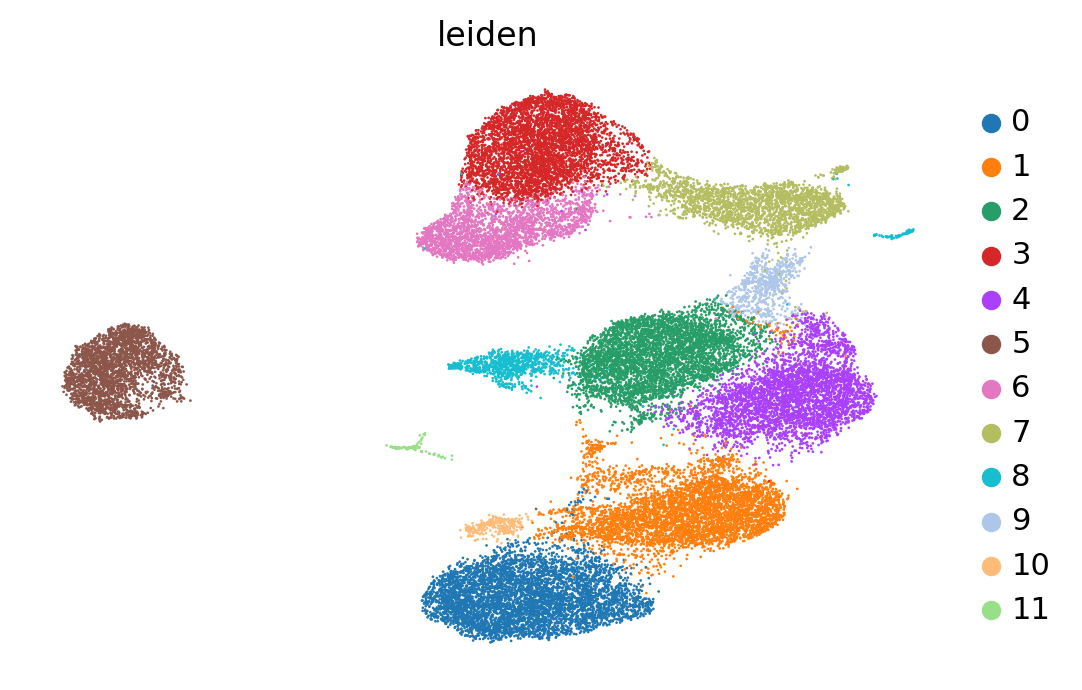

In [11]:
# plot umap to check
sc.pl.umap(adata_with_vcy, color=['leiden'], frameon=False, save='_celltypes_with_vcy.pdf')


## 3. Compute velocity from the spliced/unspliced classified reads

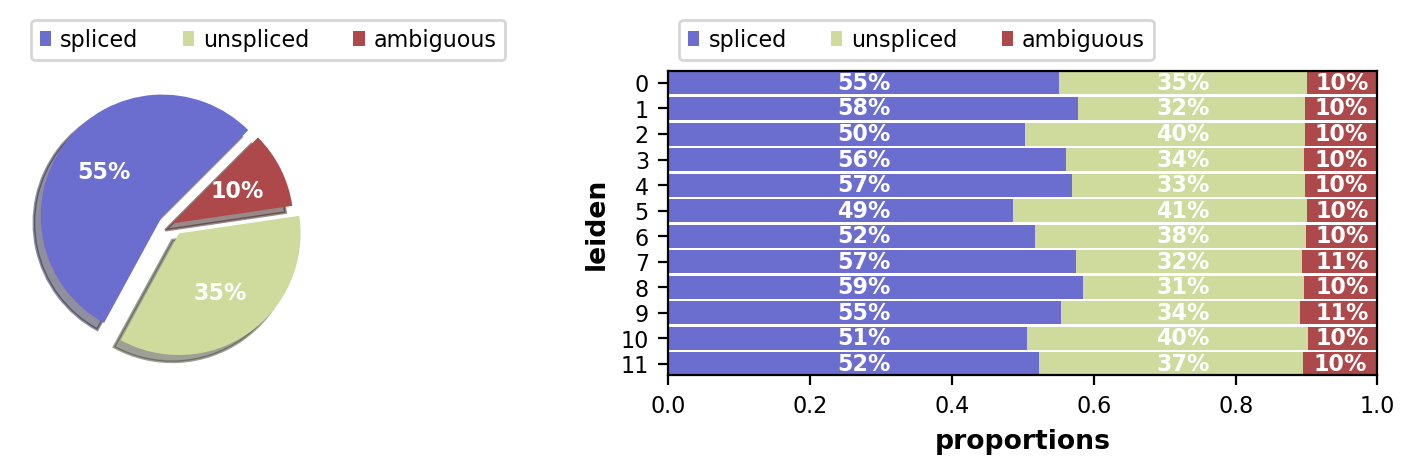

In [8]:
scv.pl.proportions(adata_with_vcy, groupby='leiden')

In [9]:
# pre-process the data
scv.pp.filter_and_normalize(adata_with_vcy)
scv.pp.moments(adata_with_vcy)

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Logarithmized X.
computing moments based on connectivities
    finished (0:00:23) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [10]:
# compute velocity
scv.tl.velocity(adata_with_vcy, mode='stochastic')
scv.tl.velocity_graph(adata_with_vcy)

computing velocities
    finished (0:00:39) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/128 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:01:49) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:07) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_embedding.pdf


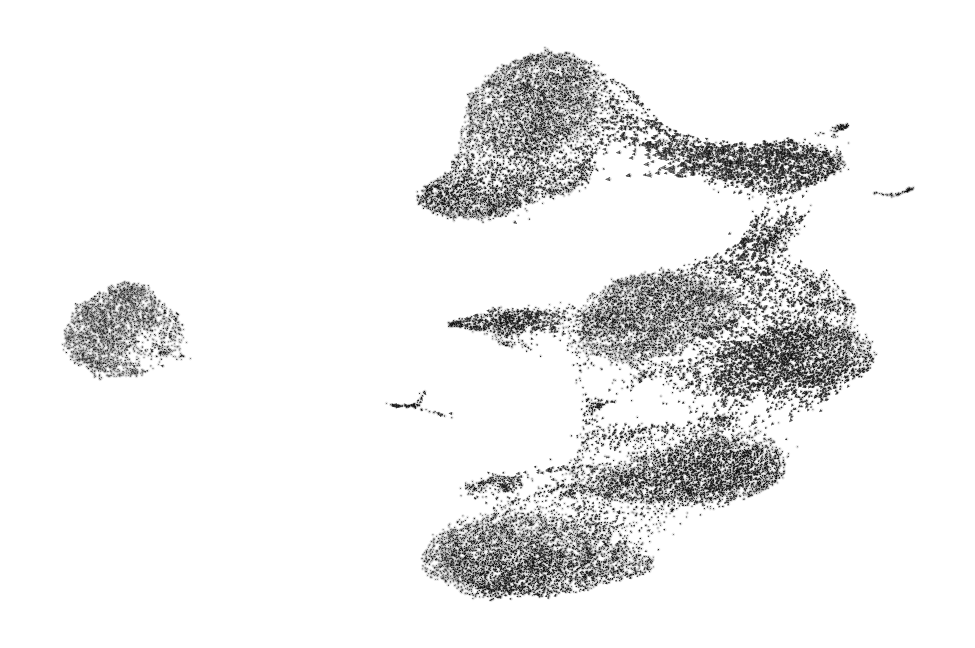

In [17]:
scv.pl.velocity_embedding(adata_with_vcy, basis='umap', frameon=False, save='embedding.pdf')

saving figure to file ./figures/scvelo_embedding_grid.pdf


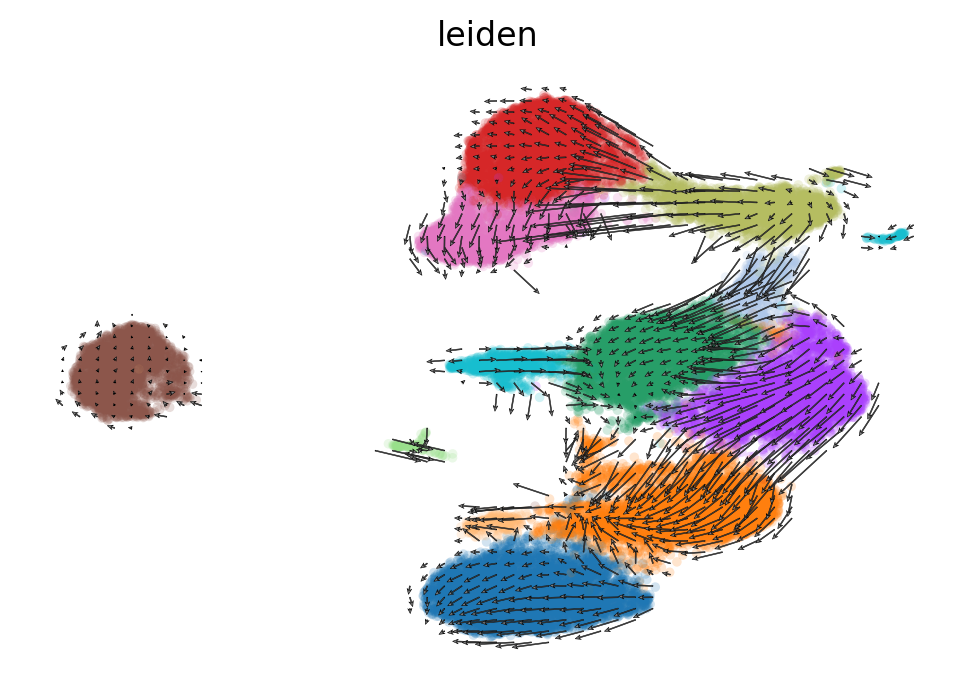

In [18]:
scv.pl.velocity_embedding_grid(adata_with_vcy, basis='umap', color='leiden', save='embedding_grid.pdf', scale=0.25)

the obs value 'sample_batch' has more than 103 categories. Uniform 'grey' color will be used for all categories.
figure cannot be saved as pdf, using png instead (can only output finite numbers in pdf).
saving figure to file ./figures/scvelo_embedding_stream.png


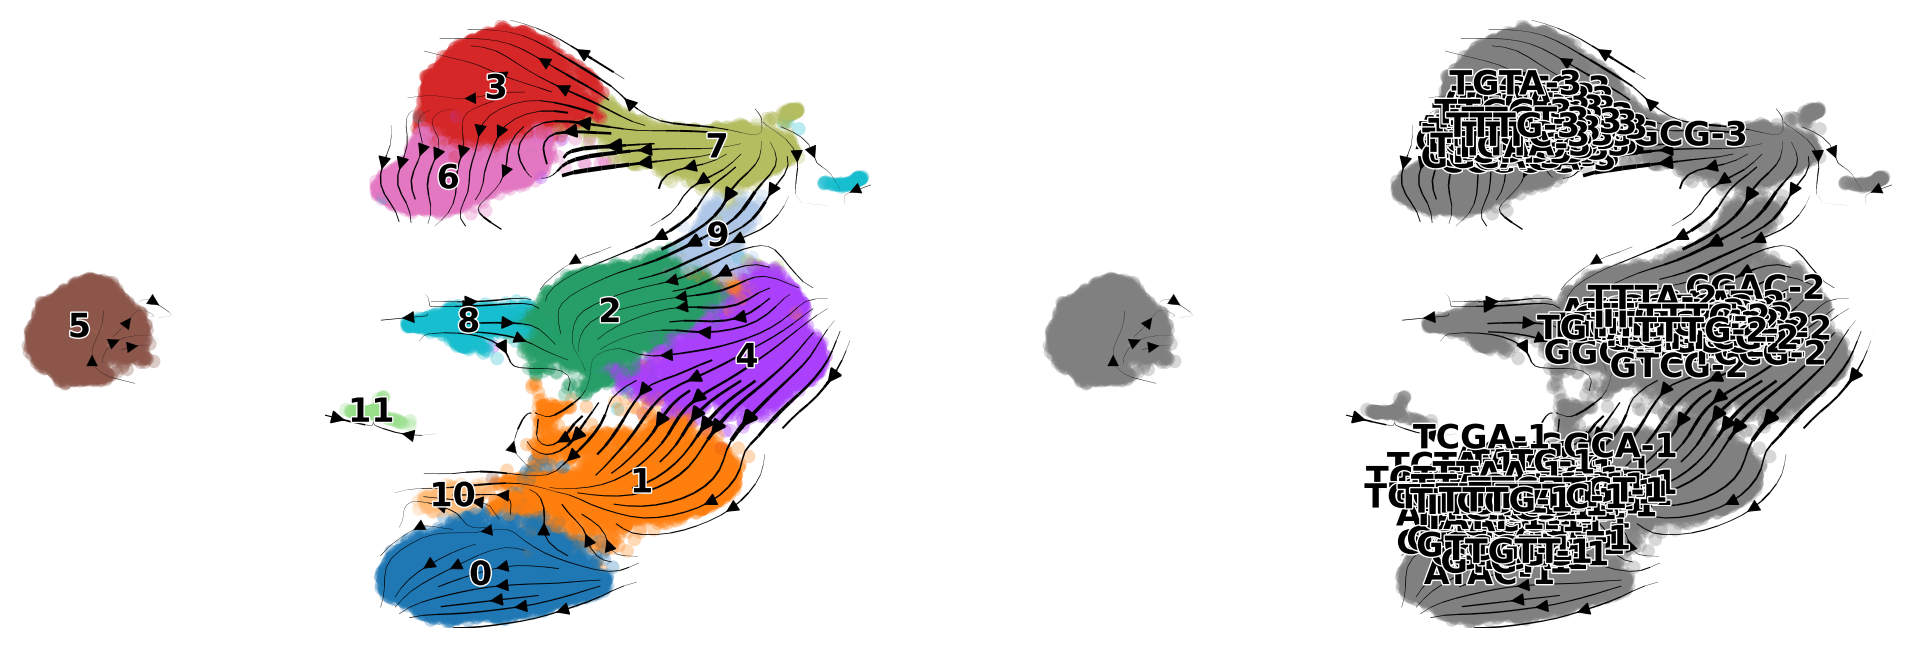

In [20]:
#load the already saved anndata
adata_with_vcy = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/adata_aggregated_with_vcy.h5ad')
scv.pl.velocity_embedding_stream(adata_with_vcy, basis='umap', color=['leiden', 'batch'], save='embedding_stream.pdf', title='')

#### get pseudotime trajectory per cell

In [16]:
scv.tl.rank_velocity_genes(adata_with_vcy, groupby='leiden', min_corr=.3)
#save dataframe csv
pd.DataFrame(adata_with_vcy.uns["rank_velocity_genes"]["names"]).to_csv('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/ranked_velocity_genes.csv')
print(pd.DataFrame(adata_with_vcy.uns["rank_velocity_genes"]["names"]).head(10))


ranking velocity genes
    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)
           0         1       2        3          4        5           6  \
0       BCL2  HSP90AB1  CC2D2B      AUH       MYOF  EIF2AK3      SETBP1   
1      MDFIC  HLA-DQB1   STAT4     PBX3         F5     CD55  AC023590.1   
2    B4GALT5    MALAT1    JAK2    STK39    GRAMD1B    YPEL5       WDFY4   
3      ABTB2     CMSS1   LRRK2   ATP8B4     SLC2A5    BANK1         AUH   
4      MAML2     HSPD1   MTSS1   CFAP57      KLHL6   ADAM28      TBC1D9   
5  LINC00158      FLT1  CEP112    WDFY4      ARAP2    NR4A2     CCDC141   
6     ZNF318     HSPA8    RGCC  GRAMD1B      STAT1    BACH2        PTEN   
7    ST8SIA4      CDK6  CLEC2D     LY75     GPR183    FCRL1       ARAP2   
8    MACROD2       TOX    DTX1   STK38L  MIR3945HG     UTRN       ENPP3   
9        KMO       PHB   MBNL1  RPS6KA2        SYK  COL19A1   

In [22]:
scv.tl.velocity_confidence(adata_with_vcy)
# inspect velocity confidence
adata_with_vcy.obs


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)


cell_type_major  n_genes  n_genes_by_counts  total_counts  \
AAACAGCCAAAG            day0_2      916                915        1483.0   
AAACAGCCAAGC            day5_6     3582               3580        8281.0   
AAACAGCCAAGG            day0_2     2416               2415        4951.0   
AAACAGCCAAGT            day0_2     1435               1435        2449.0   
AAACAGCCAATA            day0_2     1349               1349        2316.0   
...                        ...      ...                ...           ...   
TTTGTTGGTTTA            day0_2     1205               1205        2080.0   
TTTGTTGGTTTA-1          day0_2     1037               1037        1645.0   
TTTGTTGGTTTA-2          day3_4     3668               3665        9880.0   
TTTGTTGGTTTC            day5_6     3396               3395        7535.0   
TTTGTTGGTTTG            day3_4     4273               4271       11710.0   

                total_counts_mt  pct_counts_mt   topic_0   topic_1   topic_2  \
AAACAGCCAAAG               46.0       3.101821  0.008554  0.013326  0.005968   
AAACAGCCAAGC              846.0      10.216157  0.018575  0.013160  0.008065   
AAACAGCCAAGG              471.0       9.513230  0.038631  0.025551  0.318661   
AAACAGCCAAGT              216.0       8.819926  0.015908  0.023365  0.006621   
AAACAGCCAATA              138.0       5.958549  0.011711  0.010980  0.044246   
...                         ...            ...       ...       ...       ...   
TTTGTTGGTTTA              180.0       8.653847  0.015295  0.009921  0.008505   
TTTGTTGGTTTA-1            115.0       6.990881  0.029035  0.010833  0.004626   
TTTGTTGGTTTA-2           1349.0      13.653846  0.037438  0.088532  0.019982   
TTTGTTGGTTTC              576.0       7.644326  0.012554  0.016904  0.005928   
TTTGTTGGTTTG              985.0       8.411613  0.035164  0.308480  0.013582   

                 topic_3  ...  Clusters  batch  initial_size_unspliced  \
AAACAGCCAAAG    0.009061  ...         3      0                     454   
AAACAGCCAAGC    0.036125  ...         2      2                    2376   
AAACAGCCAAGG    0.011544  ...         3      0                    1080   
AAACAGCCAAGT    0.007612  ...         1      0                     721   
AAACAGCCAATA    0.010271  ...         0      0                     649   
...                  ...  ...       ...    ...                     ...   
TTTGTTGGTTTA    0.012338  ...         4      0                     523   
TTTGTTGGTTTA-1  0.020678  ...         5      0                     601   
TTTGTTGGTTTA-2  0.024211  ...         9      1                    1925   
TTTGTTGGTTTC    0.023279  ...         7      2                    2610   
TTTGTTGGTTTG    0.014606  ...         2      1                    2813   

                initial_size_spliced  initial_size     n_counts  \
AAACAGCCAAAG                     571         571.0  1082.439819   
AAACAGCCAAGC                    2989        2989.0  2573.778076   
AAACAGCCAAGG                    2135        2135.0  2071.380615   
AAACAGCCAAGT                     859         859.0  1499.629028   
AAACAGCCAATA                     916         916.0  1435.069824   
...                              ...           ...          ...   
TTTGTTGGTTTA                     556         556.0  1316.003784   
TTTGTTGGTTTA-1                   774         774.0  1188.019531   
TTTGTTGGTTTA-2                  4241        4241.0  2490.495361   
TTTGTTGGTTTC                    2403        2403.0  2552.340332   
TTTGTTGGTTTG                    4910        4910.0  2772.896484   

                velocity_self_transition  velocity_length  \
AAACAGCCAAAG                    0.102503            14.63   
AAACAGCCAAGC                    0.123268             9.99   
AAACAGCCAAGG                    0.098099            11.54   
AAACAGCCAAGT                    0.183622             9.59   
AAACAGCCAATA                    0.196343            12.64   
...                                  ...              ...   
TTTGTTGGTTTA        

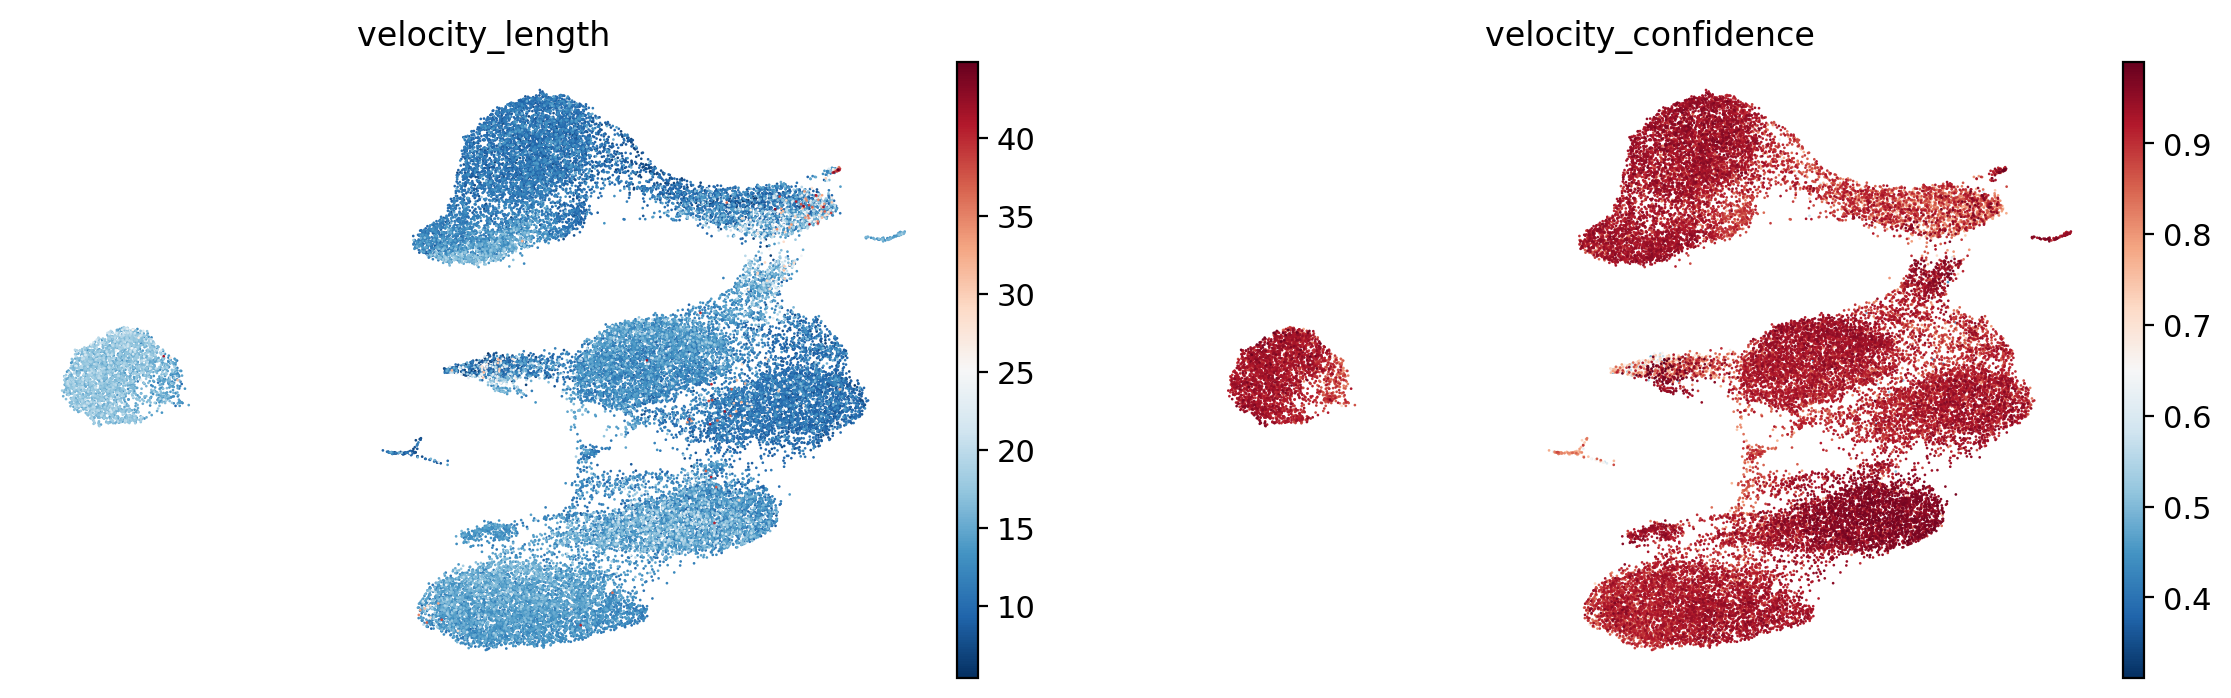

In [23]:
# plot umap to check
sc.pl.umap(adata_with_vcy, color=['velocity_length', 'velocity_confidence'], frameon=False, save='_velocity_confidence.pdf')

saving figure to file ./figures/scvelo_velocity_graph.pdf


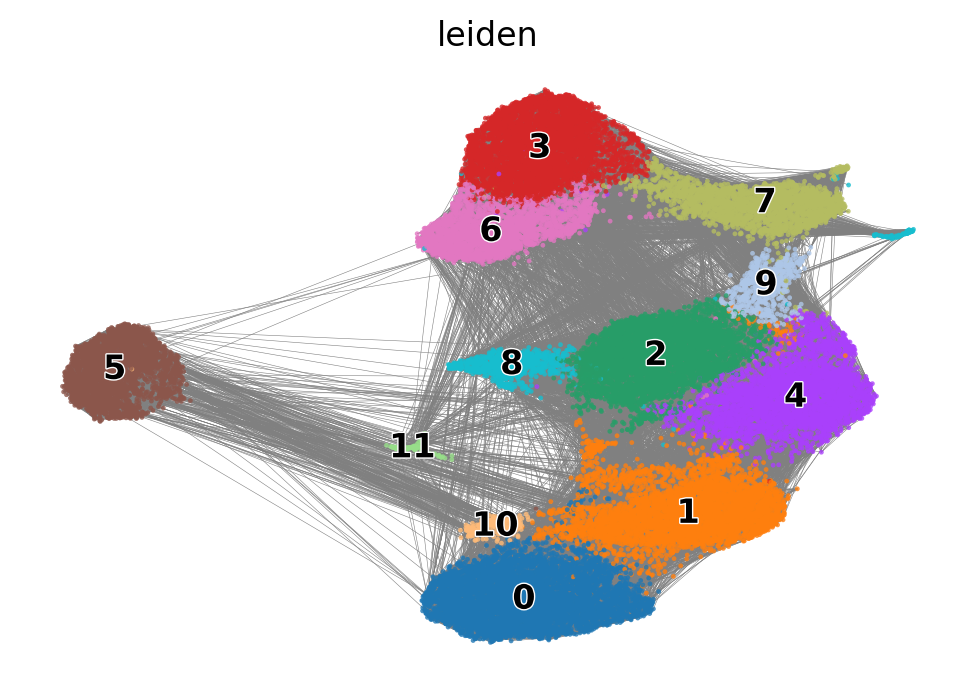

In [24]:
scv.pl.velocity_graph(adata_with_vcy, threshold=.1, color='leiden', save='velocity_graph.pdf')

#### finally get pseudotime

In [29]:
scv.tl.velocity_pseudotime(adata_with_vcy)
adata_with_vcy.obs

computing terminal states
    identified 0 region of root cells and 3 regions of end points .
    finished (0:00:04) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


cell_type_major  n_genes  n_genes_by_counts  total_counts  \
AAACAGCCAAAG            day0_2      916                915        1483.0   
AAACAGCCAAGC            day5_6     3582               3580        8281.0   
AAACAGCCAAGG            day0_2     2416               2415        4951.0   
AAACAGCCAAGT            day0_2     1435               1435        2449.0   
AAACAGCCAATA            day0_2     1349               1349        2316.0   
...                        ...      ...                ...           ...   
TTTGTTGGTTTA            day0_2     1205               1205        2080.0   
TTTGTTGGTTTA-1          day0_2     1037               1037        1645.0   
TTTGTTGGTTTA-2          day3_4     3668               3665        9880.0   
TTTGTTGGTTTC            day5_6     3396               3395        7535.0   
TTTGTTGGTTTG            day3_4     4273               4271       11710.0   

                total_counts_mt  pct_counts_mt   topic_0   topic_1   topic_2  \
AAACAGCCAAAG               46.0       3.101821  0.008554  0.013326  0.005968   
AAACAGCCAAGC              846.0      10.216157  0.018575  0.013160  0.008065   
AAACAGCCAAGG              471.0       9.513230  0.038631  0.025551  0.318661   
AAACAGCCAAGT              216.0       8.819926  0.015908  0.023365  0.006621   
AAACAGCCAATA              138.0       5.958549  0.011711  0.010980  0.044246   
...                         ...            ...       ...       ...       ...   
TTTGTTGGTTTA              180.0       8.653847  0.015295  0.009921  0.008505   
TTTGTTGGTTTA-1            115.0       6.990881  0.029035  0.010833  0.004626   
TTTGTTGGTTTA-2           1349.0      13.653846  0.037438  0.088532  0.019982   
TTTGTTGGTTTC              576.0       7.644326  0.012554  0.016904  0.005928   
TTTGTTGGTTTG              985.0       8.411613  0.035164  0.308480  0.013582   

                 topic_3  ...  initial_size_spliced  initial_size  \
AAACAGCCAAAG    0.009061  ...                   571         571.0   
AAACAGCCAAGC    0.036125  ...                  2989        2989.0   
AAACAGCCAAGG    0.011544  ...                  2135        2135.0   
AAACAGCCAAGT    0.007612  ...                   859         859.0   
AAACAGCCAATA    0.010271  ...                   916         916.0   
...                  ...  ...                   ...           ...   
TTTGTTGGTTTA    0.012338  ...                   556         556.0   
TTTGTTGGTTTA-1  0.020678  ...                   774         774.0   
TTTGTTGGTTTA-2  0.024211  ...                  4241        4241.0   
TTTGTTGGTTTC    0.023279  ...                  2403        2403.0   
TTTGTTGGTTTG    0.014606  ...                  4910        4910.0   

                   n_counts  velocity_self_transition  velocity_length  \
AAACAGCCAAAG    1082.439819                  0.102503            14.63   
AAACAGCCAAGC    2573.778076                  0.123268             9.99   
AAACAGCCAAGG    2071.380615                  0.098099            11.54   
AAACAGCCAAGT    1499.629028                  0.183622             9.59   
AAACAGCCAATA    1435.069824                  0.196343            12.64   
...                     ...                       ...              ...   
TTTGTTGGTTTA    1316.003784                  0.237092            13.78   
TTTGTTGGTTTA-1  1188.019531                  0.304444            11.74   
TTTGTTGGTTTA-2  2490.495361                  0.170179             7.82   
TTTGTTGGTTTC    2552.340332                  0.247516            12.72   
TTTGTTGGTTTG    2772.896484                  0.144186            10.12   

                velocity_confidence  velocity_confidence_transition  \
AAACAGCCAAAG               0.876819                        0.214056   
AAACAGCCAAGC               0.929361                        0.359555   
AAACAGCCAAGG               0.949199                        0.750392   
AAACAGCCAAGT               0.755662                        0.151479   
AAACAGCCAATA               0.827077                        0.107483 

In [30]:
# this is needed due to a current bug - bugfix is coming soon.
adata_with_vcy.uns['neighbors']['distances'] = adata_with_vcy.obsp['distances']
adata_with_vcy.uns['neighbors']['connectivities'] = adata_with_vcy.obsp['connectivities']

In [31]:
scv.tl.paga(adata_with_vcy, groups='leiden')
df = scv.get_df(adata_with_vcy, 'paga/transitions_confidence', precision=2).T

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:08) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


saving figure to file ./figures/scvelo_paga_velocity_cluster_movement.pdf


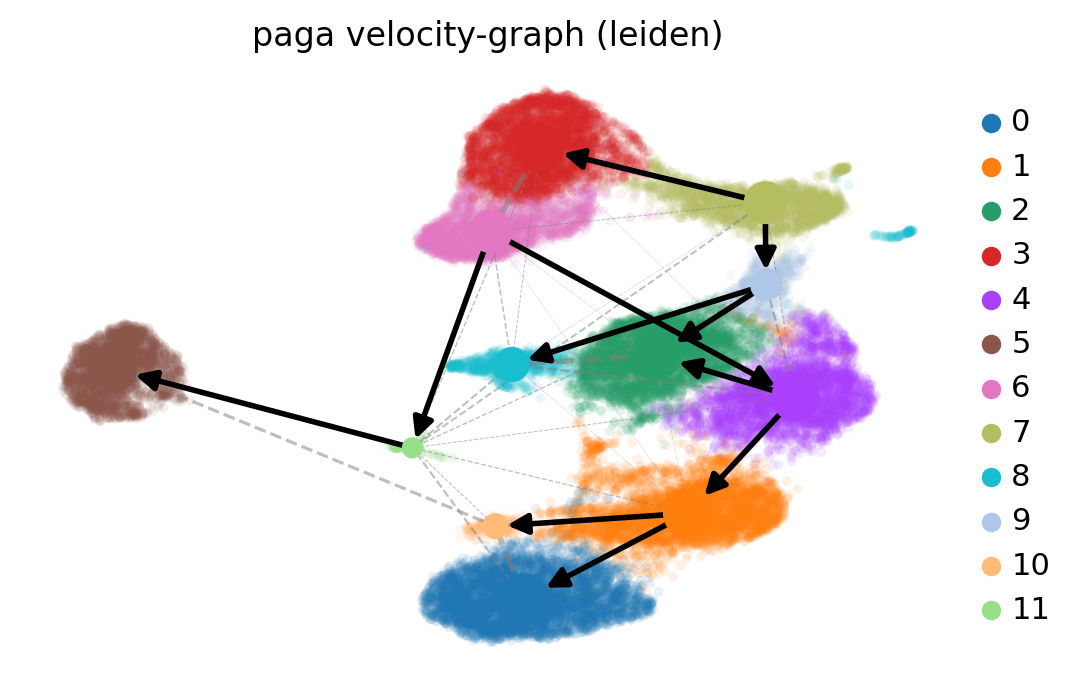

In [33]:
scv.pl.paga(adata_with_vcy, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5, save='paga_velocity_cluster_movement.pdf')

In [34]:
#save new adata object with velocity calculated 
adata_with_vcy.write('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/adata_aggregated_with_vcy.h5ad')